# Sprint 2

## Podcast listeners client base demographic Segmentation

### Motivation
Podcast space is a growing media space. Publishers and advertising agencies have been having a challenge in identifying different segments of listeners within this space. This might be due to the fact the industry is new and data around this industry is scattered and challenging to put together to make a picture of its audience.

### Result
Here we present a research study on podcast listeners data using advanced analytical methods to identify listeners segments. Take Netflix as an example, they are able to segment their user base in a way they can recommend existing content to them or identify what kind of new content to invest in and produce. For us here we attempt to provide something similar. We will provide meaningful insights to help publishers and advertising agencies reach their target audience.

### Research question
What are the various podcast listeners characteristic, trends and demographics segments in the Canadian podcast space?

### Sprint 1
In this sprint we are going to be focusing on exploring our data, conducting data cleaning and getting data to be more readable and ready for exploration

### What is needed
We are going to be using Python as a programing language. We are going to be using the following libararies in Sprint 1:
1. Pandas
2. Numpy
3. matplotlib
4. seaborn
5. sklearn

### Summary of Findings - conclusion of analysis
There are 3 segments of podcast listeners.
1. First segment is: 
We can tell that for Cluster One it is characterized by older age listeners in which it is mostly composed of listeners who are 60 years old or above. They mostly reside in Ontario and Quebec they are male dominant. Their top category they listen to is News/Politics and Society/Culture and they are characterized by average income of 80K per year.
    
2. Second Segmen is:
As for cluster two it is characterized by Young again but it is very female dominant. They mostly reside in Quebec and their top listening category is Comedy similar to Cluster one.

3. Third Segmen is:
As for cluster Three is characterized by Young age, male dominant and their top listening category is Comedy and they mostly live in Ontario and British Columbia and their average high income of 106K per year.
    

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [44]:
#import all cleaned data -- from sprint 1
new_num_data = pd.read_csv('./new_num_data.csv')
numeric_data = pd.read_csv('./num_data.csv')
categorical_data = pd.read_csv('./cat_data.csv')
kyc_data = pd.read_csv('./kyc_data.csv')

# Utilize unsupervised Principal Component analysis algorithim to reduce dimentions

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
scaler = StandardScaler()
scaler.fit(new_num_data)

C:\Users\omarh\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [47]:
scaled_data = scaler.transform(new_num_data)

C:\Users\omarh\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [48]:
from sklearn.decomposition import PCA

In [49]:
#reduce data variables into 2 components
pca = PCA(n_components=2)

In [50]:
pca.fit(scaled_data)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [51]:
x_pca = pca.transform(scaled_data)

Text(0, 0.5, 'Second Principal Component')

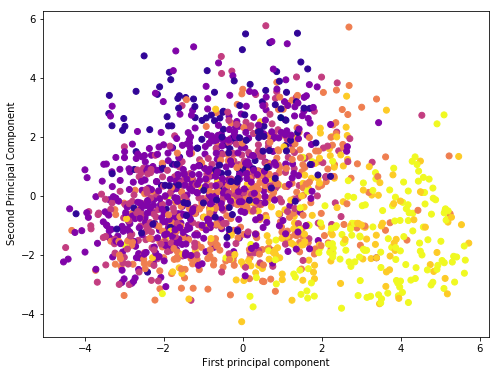

In [52]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1],c=numeric_data['Age'],cmap='plasma')
plt.xlabel('First principal component')
plt.ylabel('Second Principal Component')

In [53]:
df_comp = pd.DataFrame(pca.components_,columns=new_num_data.columns.tolist())

# heatmap to visualize co-relation of each variable to both PCA components

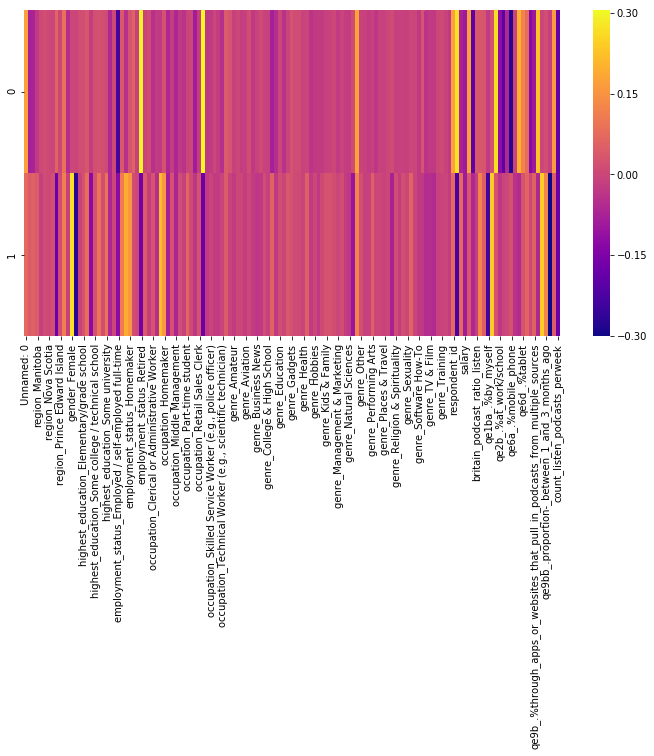

In [54]:
plt.figure(figsize=(12,6))
sns.heatmap(df_comp,cmap='plasma',)

# fit PCA scores into Clustering KMeans unsupervised algorithim

In [55]:
from sklearn.cluster import KMeans

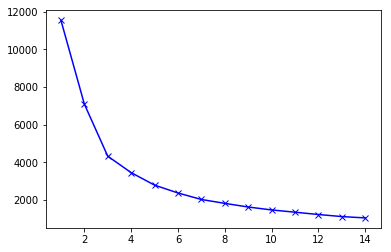

In [56]:
#before we fit the data into the clustering model, we need to determine approporiate number of clusters & for that
#we are going to use sum of squared distances AKA elbow method
sum_of_squared_distances = []

for k in range(1,15):
    km = KMeans(n_clusters=k)
    km = km.fit(x_pca)
    sum_of_squared_distances.append(km.inertia_)
    
plt.plot(range(1,15),sum_of_squared_distances, 'bx-')
plt.show()

### Here in the figure above we can see optimal number of clusters is 3 as after 3 number of clusters doesnt add much value

# KMeans CLUSTERING

In [57]:
kmeans = KMeans(n_clusters=3, init = 'k-means++')

In [58]:
y_kmeans = kmeans.fit_predict(x_pca)

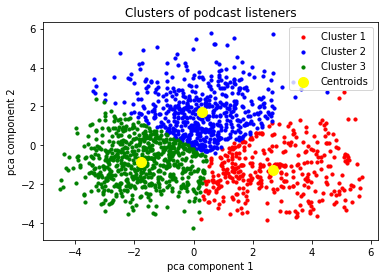

In [60]:
plt.scatter(x_pca[y_kmeans == 0, 0], x_pca[y_kmeans == 0, 1], s = 10, c = 'red', label = 'Cluster 1')
plt.scatter(x_pca[y_kmeans == 1, 0], x_pca[y_kmeans == 1, 1], s = 10, c = 'blue', label = 'Cluster 2')
plt.scatter(x_pca[y_kmeans == 2, 0], x_pca[y_kmeans == 2, 1], s = 10, c = 'green', label = 'Cluster 3')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 100, c = 'yellow', label = 'Centroids')
plt.title('Clusters of podcast listeners')
plt.xlabel('pca component 1')
plt.ylabel('pca component 2')
plt.legend()
plt.show()

## As you can see in the above figure, there are 3 different clear clusters of podcast listeners

## Now what we have to do is determine the podcast listeners ID and then mine that off the KYC table we have

In [61]:
lables = kmeans.labels_
new_num_data['clusters'] = lables

In [62]:
#assign clusters and their responded id to a variable
num_data_clust = new_num_data[['respondent_id','clusters']]

In [63]:
num_data_clust
merged_keyc_numeric  = kyc_data.merge(num_data_clust, on='respondent_id', how='inner')
kyc_grouping = merged_keyc_numeric[['clusters','salary','Age', 'household_size']].groupby(['clusters',]).mean().astype(int)
kyc_grouping = merged_keyc_numeric[['clusters','salary','Age', 'household_size']].groupby(['clusters',]).mean().astype(int)

In [64]:
size_gp_gender = merged_keyc_numeric.groupby(['clusters','gender']).size().to_frame("total").reset_index()

In [65]:
def get_count_by_column(df, column_name, target_values):
    return len(df[df[column_name] in target_values])    
def get_ratio(df, column_name, filter_name=None, filter_value=None):
    if filter_name is not None:
        print("here")
        df = df[df[filter_name] == filter_value]
        print(len(df))
    df = df[column_name].value_counts(normalize=True).to_frame("percentage") * (100)
    df.rename_axis(column_name, inplace=True)
    return df

# ANALYSIS

### Now, lets take a look at gender ratio in each cluster

here
350
here
557
here
627


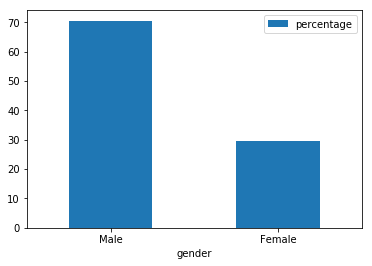

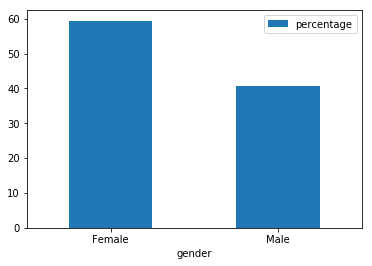

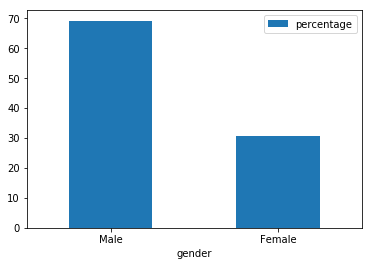

In [66]:
get_ratio(df=merged_keyc_numeric, column_name='gender', filter_name='clusters', filter_value=0).plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='gender', filter_name='clusters', filter_value=1).plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='gender', filter_name='clusters', filter_value=2).plot.bar(rot=0)

We can tell that cluster one and two are male dominante and cluster 3 is female dominate

### Now, lets take a look at top 5 regions ratio in each cluster

here
350
here
557
here
627


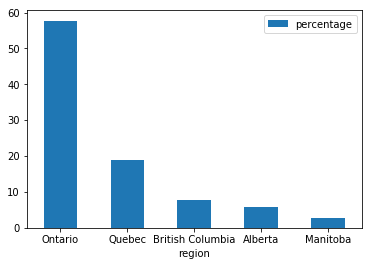

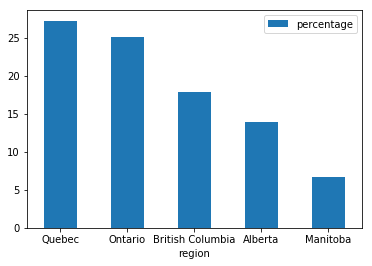

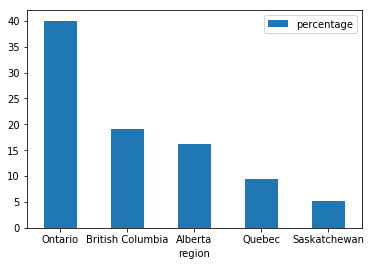

In [67]:
get_ratio(df=merged_keyc_numeric, column_name='region', filter_name='clusters', filter_value=0)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='region', filter_name='clusters', filter_value=1)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='region', filter_name='clusters', filter_value=2)[:5].plot.bar(rot=0)

We can tell that cluster one 40% of podcast listenrs are in Ontario and 20% are in BC. While Cluster 2 is almost 60% Ontario and 20% Quebec. As for Cluster 3 it is Quebec coming as number 1 at 30% and Ontario coming second at almost 25%

here
350
here
557
here
627


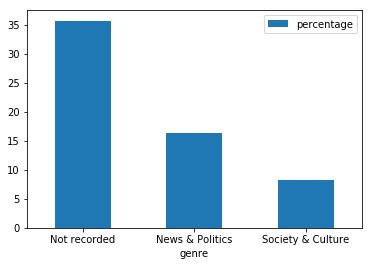

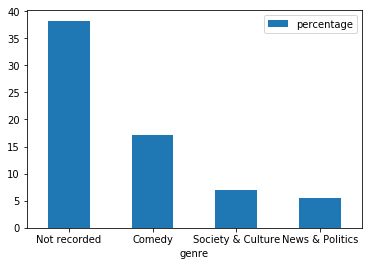

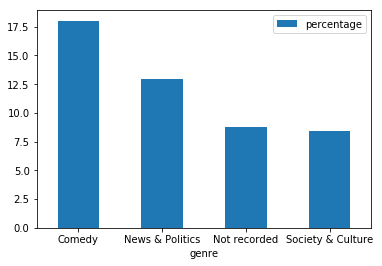

In [68]:
get_ratio(df=merged_keyc_numeric, column_name='genre', filter_name='clusters', filter_value=0)[:3].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='genre', filter_name='clusters', filter_value=1)[:4].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='genre', filter_name='clusters', filter_value=2)[:4].plot.bar(rot=0)

We can see that cluster one the top category is Comedy and News/Politics coming second. As for cluster 2 35% of participants decided not to indicate their favorite category however, we can see that news/politics are the next top listened to category.
As for cluster 3 we can see that Comedy is the top listened to category with Society/culture coming next

here
350
here
557
here
627


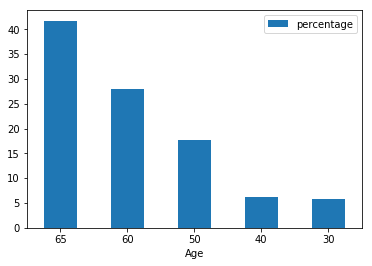

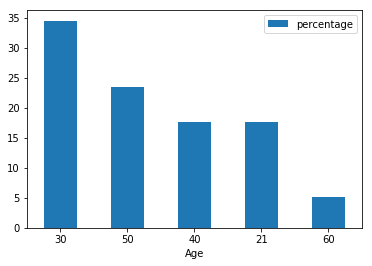

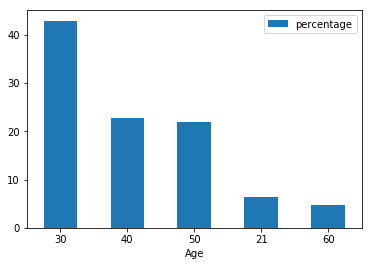

In [69]:
get_ratio(df=merged_keyc_numeric, column_name='Age', filter_name='clusters', filter_value=0)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='Age', filter_name='clusters', filter_value=1)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='Age', filter_name='clusters', filter_value=2)[:5].plot.bar(rot=0)

We can tell that cluster one and three is young listerners with average age 30 and 40 making up over 60% of the listeners.
As for cluster 2 it is dominated by older age with age 60 and above make up more than 70% of the listeners


here
350
here
557
here
627


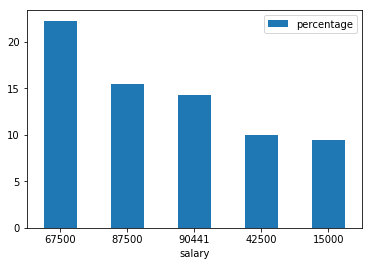

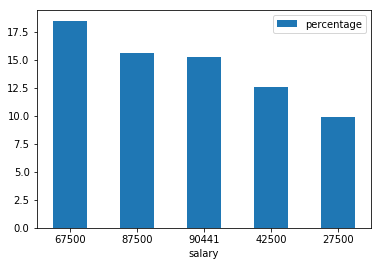

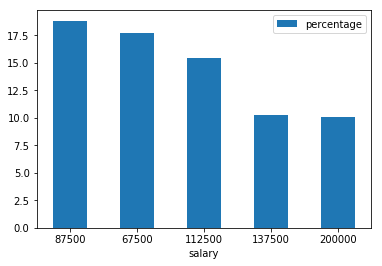

In [70]:
get_ratio(df=merged_keyc_numeric, column_name='salary', filter_name='clusters', filter_value=0)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='salary', filter_name='clusters', filter_value=1)[:5].plot.bar(rot=0)
get_ratio(df=merged_keyc_numeric, column_name='salary', filter_name='clusters', filter_value=2)[:5].plot.bar(rot=0)

Here we can use the plot of salaries for each cluster

In [76]:
 # average of salary per cluster
(merged_keyc_numeric.groupby(['clusters'], as_index=False).mean()
            .groupby('clusters')['salary'].mean())

clusters
0     80891.571429
1     78850.960503
2    106068.095694
Name: salary, dtype: float64